In [27]:
import sys

sys.path.append("ml-tools-direct-method")
from pathlib import Path

In [2]:
from tools.bandit import generate_bandit_feedback
from tools.estimate import get_estimator_stats, get_value_estimators
from tools.policy import ModelPolicy, UniformPolicy
from tools.utils import datasets, get_bandit, split_data

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_palette("colorblind")
colors = sns.color_palette()
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 14

X_MED = 10
Y_MED = 6
XY_MED = (X_MED, Y_MED)

In [4]:
SKIP_NONLIN = False
NUM_TRIALS = 500

## Experiments with Small Public Datasets 

In [5]:
frames = {}
for data in datasets:

    if data in [
        "satimage",
        "vehicle",
        #"pendigits",
    ]:  # skip these for now, I don't expect them to converge in a linear model.
        continue

    # configure dataset into bandit setting
    contexts, full_rewards, best_actions = get_bandit(data)
    n, k = full_rewards.shape
    _, d = contexts.shape
    print(
        f"This dataset has {k} actions, the context space has {d} dimensions, and there are {n} examples."
    )

    # split train test sets
    rng = default_rng(3)
    X_train, y_train, X_test, y_test, full_rewards_test = split_data(
        contexts, full_rewards, best_actions, rng
    )

    # create target policy using logreg
    print("Fitting target policy")
    model = LogisticRegression(multi_class="multinomial", max_iter=10000)
    model.fit(X_train, y_train)
    target_policy = ModelPolicy(model=model, num_actions=k)
    # get true value of target policy -> treated as ground truth for comparing estimates
    target_policy_true_value = target_policy.get_value_estimate(
        X_test, full_rewards_test
    )

    # create logging policy
    logging_policy = UniformPolicy(num_actions=k)

    # run 500 simulations
    trials = NUM_TRIALS
    val_ests = []
    policy = target_policy
    policy_true_value = policy.get_value_estimate(X_test, full_rewards_test)
    rng = default_rng(6)
    print("Simulating...")
    for i in tqdm(range(trials)):
        contexts, actions, rewards, propensities = generate_bandit_feedback(
            X_test, full_rewards_test, logging_policy, rng=rng
        )
        est = get_value_estimators(
            policy,
            contexts,
            actions,
            rewards,
            propensities,
            skip_nonlin=SKIP_NONLIN,
        )
        val_ests.append(est)

    df = pd.DataFrame(val_ests)
    print(f"Target policy true value {target_policy_true_value}.")
    df_stats = get_estimator_stats(df, true_parameter_value=policy_true_value)
    df_stats["true"] = policy_true_value
    print(df_stats)

    frames[data] = df_stats

Loaded ecoli from local csv
This dataset has 8 actions, the context space has 7 dimensions, and there are 336 examples.


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting target policy
Simulating...


100%|██████████| 500/500 [09:03<00:00,  1.09s/it]


Target policy true value 0.5528155516354646.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.551016  0.117532  0.013814  0.005256  0.001800  0.117546   
1         dm  0.500704  0.053915  0.002907  0.002411  0.052111  0.074983   
2      dm_iw  0.555676  0.054198  0.002937  0.002424  0.002860  0.054273   
3     dm_log  0.328407  0.051245  0.002626  0.002292  0.224409  0.230185   
4  dm_log_iw  0.545652  0.054210  0.002939  0.002424  0.007163  0.054681   
5         dr  0.547337  0.053889  0.002904  0.002410  0.005479  0.054167   
6     dr_log  0.539893  0.070707  0.004999  0.003162  0.012923  0.071878   
7      dm_rf  0.338710  0.104861  0.010996  0.004690  0.214106  0.238405   
8      dr_rf  0.501532  0.075024  0.005629  0.003355  0.051283  0.090877   

       true  
0  0.552816  
1  0.552816  
2  0.552816  
3  0.552816  
4  0.552816  
5  0.552816  
6  0.552816  
7  0.552816  
8  0.552816  
Loaded glass from local csv
This dataset has 6 actions

  0%|          | 0/500 [00:00<?, ?it/s]

Simulating...


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


Target policy true value 0.461639084435439.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.461416  0.106691  0.011383  0.004771  0.000223  0.106691   
1         dm  0.416748  0.085612  0.007329  0.003829  0.044891  0.096668   
2      dm_iw  0.450746  0.097521  0.009510  0.004361  0.010893  0.098127   
3     dm_log  0.367984  0.067007  0.004490  0.002997  0.093655  0.115157   
4  dm_log_iw  0.437093  0.075474  0.005696  0.003375  0.024546  0.079366   
5         dr  0.444815  0.088190  0.007778  0.003944  0.016824  0.089781   
6     dr_log  0.431453  0.075568  0.005710  0.003379  0.030186  0.081374   
7      dm_rf  0.178958  0.145740  0.021240  0.006518  0.282681  0.318039   
8      dr_rf  0.424330  0.100864  0.010174  0.004511  0.037309  0.107543   

       true  
0  0.461639  
1  0.461639  
2  0.461639  
3  0.461639  
4  0.461639  
5  0.461639  
6  0.461639  
7  0.461639  
8  0.461639  
Loaded letter-recognition from local csv
This dataset h

  0%|          | 0/500 [00:00<?, ?it/s]

Simulating...


100%|██████████| 500/500 [1:12:07<00:00,  8.65s/it]


Target policy true value 0.642217470789697.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.641183  0.035305  0.001246  0.001579  0.001034  0.035320   
1         dm  0.217735  0.009205  0.000085  0.000412  0.424482  0.424582   
2      dm_iw  0.622712  0.018053  0.000326  0.000807  0.019505  0.026577   
3     dm_log  0.419796  0.012789  0.000164  0.000572  0.222421  0.222789   
4  dm_log_iw  0.602489  0.016290  0.000265  0.000728  0.039728  0.042938   
5         dr  0.623382  0.025870  0.000669  0.001157  0.018835  0.032001   
6     dr_log  0.600005  0.019008  0.000361  0.000850  0.042212  0.046294   
7      dm_rf  0.192306  0.025100  0.000630  0.001122  0.449911  0.450611   
8      dr_rf  0.475724  0.021527  0.000463  0.000963  0.166494  0.167879   

       true  
0  0.642217  
1  0.642217  
2  0.642217  
3  0.642217  
4  0.642217  
5  0.642217  
6  0.642217  
7  0.642217  
8  0.642217  
Loaded optdigits from local csv
This dataset has 10 act

  0%|          | 0/500 [00:00<?, ?it/s]

Simulating...


100%|██████████| 500/500 [25:48<00:00,  3.10s/it]


Target policy true value 0.9554716141655437.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.962007  0.053774  0.002892  0.002405  0.006535  0.054170   
1         dm  0.687065  0.014497  0.000210  0.000648  0.268406  0.268798   
2      dm_iw  0.919956  0.020466  0.000419  0.000915  0.035516  0.040991   
3     dm_log  0.879352  0.010017  0.000100  0.000448  0.076119  0.076775   
4  dm_log_iw  0.955912  0.007368  0.000054  0.000330  0.000440  0.007381   
5         dr  0.909151  0.019517  0.000381  0.000873  0.046321  0.050265   
6     dr_log  0.885567  0.010372  0.000108  0.000464  0.069905  0.070670   
7      dm_rf  0.646215  0.026122  0.000682  0.001168  0.309256  0.310358   
8      dr_rf  0.734289  0.025711  0.000661  0.001150  0.221183  0.222672   

       true  
0  0.955472  
1  0.955472  
2  0.955472  
3  0.955472  
4  0.955472  
5  0.955472  
6  0.955472  
7  0.955472  
8  0.955472  
Loaded pendigits from local csv
This dataset has 10 ac

/Users/amandarella/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
  0%|          | 0/500 [00:00<?, ?it/s]

Simulating...


 11%|█         | 56/500 [04:08<32:01,  4.33s/it]/Users/amandarella/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 69%|██████▉   | 345/500 [25:00<11:02,  4.28s/it]/Users/amandarella/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

Target policy true value 0.9295188641398797.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.932150  0.039223  0.001538  0.001754  0.002631  0.039311   
1         dm  0.551111  0.011609  0.000135  0.000519  0.378408  0.378586   
2      dm_iw  0.932146  0.008495  0.000072  0.000380  0.002627  0.008892   
3     dm_log  0.856739  0.009315  0.000087  0.000417  0.072779  0.073373   
4  dm_log_iw  0.914168  0.008490  0.000072  0.000380  0.015350  0.017542   
5         dr  0.920963  0.018506  0.000342  0.000828  0.008556  0.020388   
6     dr_log  0.909388  0.010696  0.000114  0.000478  0.020131  0.022796   
7      dm_rf  0.797815  0.013730  0.000189  0.000614  0.131704  0.132418   
8      dr_rf  0.835071  0.012966  0.000168  0.000580  0.094448  0.095333   

       true  
0  0.929519  
1  0.929519  
2  0.929519  
3  0.929519  
4  0.929519  
5  0.929519  
6  0.929519  
7  0.929519  
8  0.929519  
Loaded yeast from local csv
This dataset has 10 action

100%|██████████| 500/500 [12:13<00:00,  1.47s/it]

Target policy true value 0.33142895256845906.
        stat      mean        SD       var        SE      bias      RMSE  \
0         iw  0.332837  0.038789  0.001505  0.001735  0.001408  0.038815   
1         dm  0.296478  0.029199  0.000853  0.001306  0.034951  0.045543   
2      dm_iw  0.332910  0.028492  0.000812  0.001274  0.001481  0.028530   
3     dm_log  0.237831  0.023903  0.000571  0.001069  0.093598  0.096602   
4  dm_log_iw  0.328768  0.029081  0.000846  0.001301  0.002661  0.029202   
5         dr  0.330998  0.028943  0.000838  0.001294  0.000431  0.028946   
6     dr_log  0.329715  0.031232  0.000975  0.001397  0.001714  0.031279   
7      dm_rf  0.123497  0.047052  0.002214  0.002104  0.207932  0.213189   
8      dr_rf  0.267447  0.030084  0.000905  0.001345  0.063982  0.070702   

       true  
0  0.331429  
1  0.331429  
2  0.331429  
3  0.331429  
4  0.331429  
5  0.331429  
6  0.331429  
7  0.331429  
8  0.331429  


In [30]:
#save estimator dfs for each dataset (so we don't need to re-run)
if not Path("results").exists():
    Path("results").mkdir()
for frame in frames:
    frames[frame].to_csv(f"results/{frame}_results.csv")
    print(f"Saved {frame} results")

Saved ecoli results
Saved glass results
Saved letter-recognition results
Saved optdigits results
Saved yeast results
Saved pendigits results


In [34]:
#only load in datasets used
datasets = ['ecoli','glass','letter-recognition','optdigits','yeast','pendigits']

frames = {}
for data in datasets:
    frames[data] = pd.read_csv(f"results/{data}_results.csv")
    print(f"Loaded saved results for {data}")

Loaded saved results for ecoli
Loaded saved results for glass
Loaded saved results for letter-recognition
Loaded saved results for optdigits
Loaded saved results for yeast
Loaded saved results for pendigits


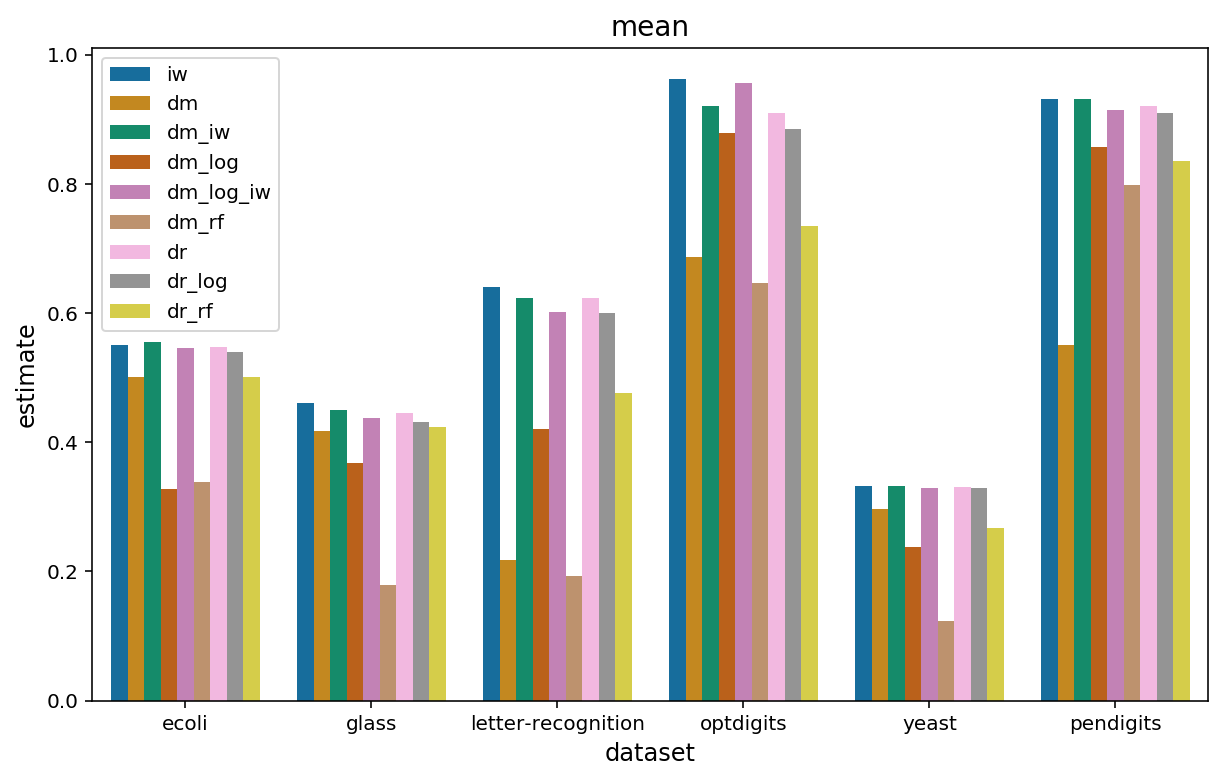

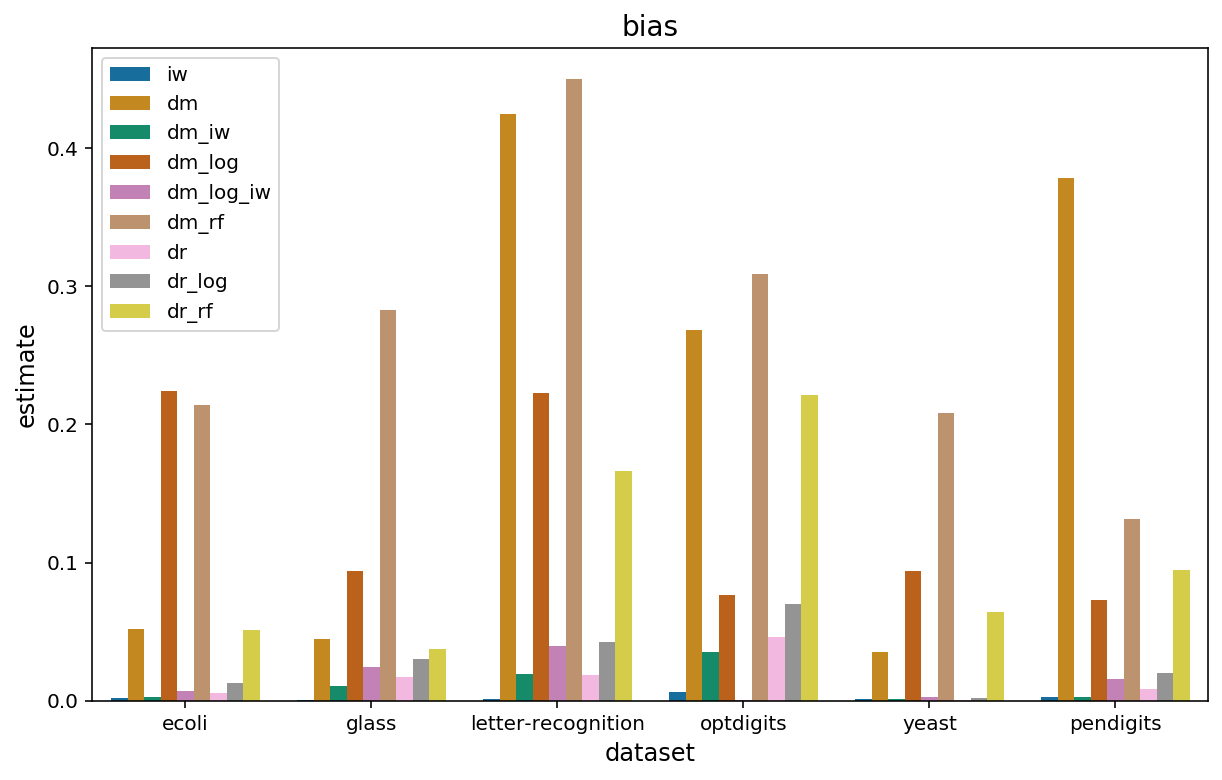

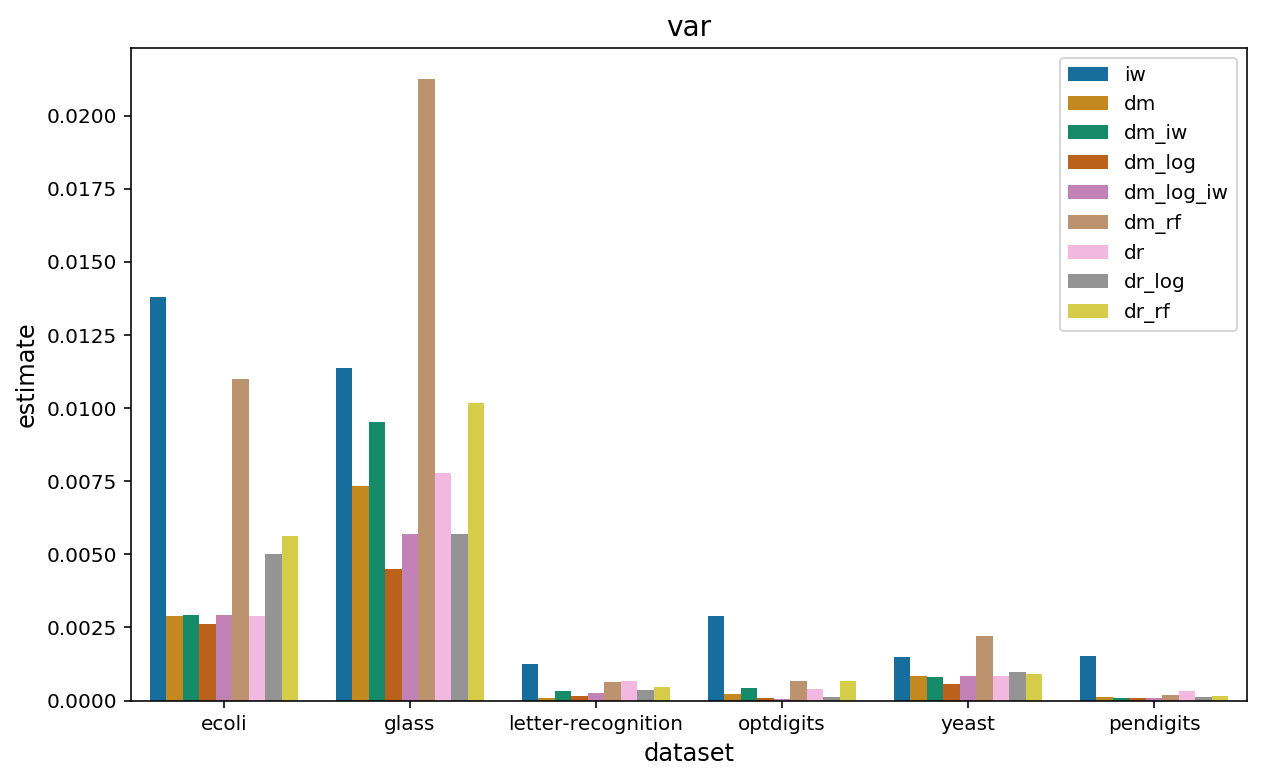

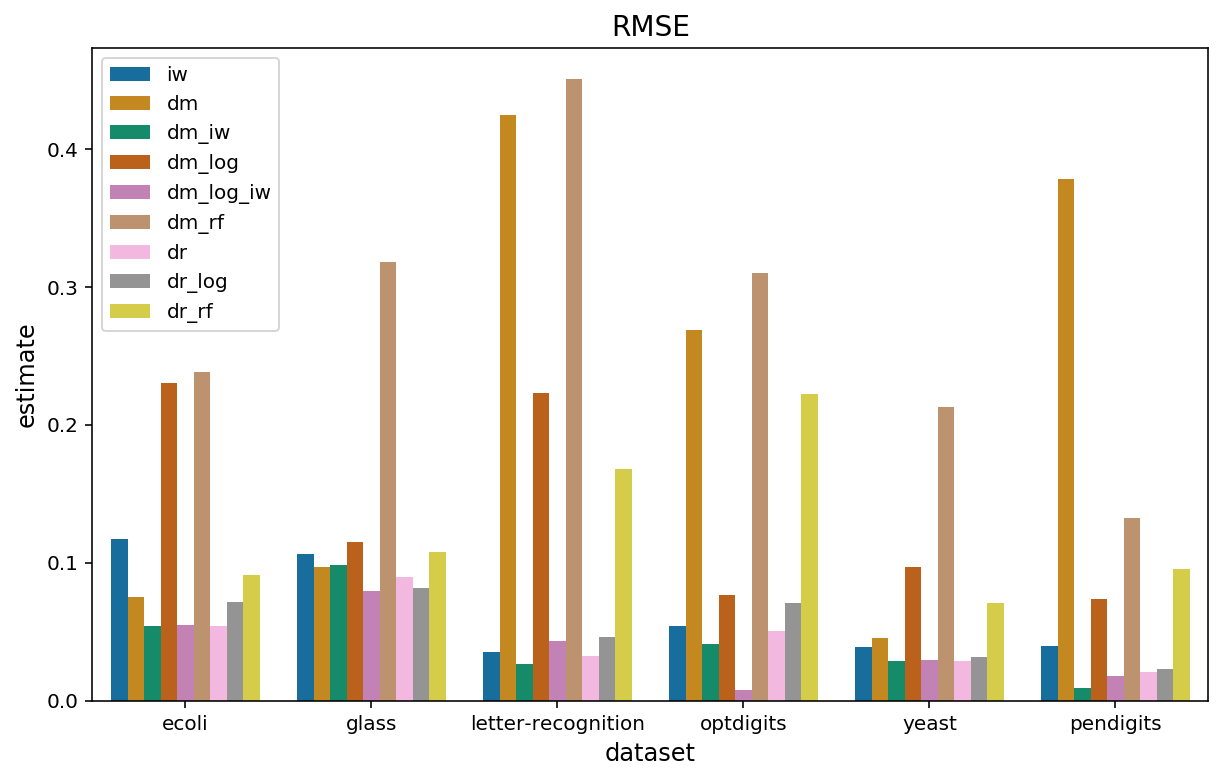

In [35]:
# visualize estimator stats for each dataset

stats = ["mean", "bias", "var", "RMSE"]
skip_nonlin = SKIP_NONLIN
for stat in stats:
    iw = []
    dm = []
    dm_iw = []
    dm_log = []
    dm_log_iw = []
    dr = []
    dr_log = []
    dm_rf = []
    dr_rf = []
    for data in datasets:

        iw.append(abs(frames[data][stat][0]))
        dm.append(abs(frames[data][stat][1]))
        dm_iw.append(abs(frames[data][stat][2]))
        dm_log.append(abs(frames[data][stat][3]))
        dm_log_iw.append(abs(frames[data][stat][4]))
        dr.append(abs(frames[data][stat][5]))
        dr_log.append(abs(frames[data][stat][6]))

        if not skip_nonlin:
            dm_rf.append(abs(frames[data][stat][7]))
            dr_rf.append(abs(frames[data][stat][8]))

    if skip_nonlin:
        df = pd.DataFrame(
            np.c_[iw, dm, dm_iw, dm_log, dm_log_iw, dr, dr_log],
            index=datasets,
            columns=["iw", "dm", "dm_iw", "dm_log", "dm_log_iw", "dr", "dr_log"],
        )
        df = (
            df.reset_index()
            .rename({"index": "dataset"}, axis=1)
            .melt(id_vars=["dataset"], var_name="estimator", value_name="estimate")
        )
    else:
        df = pd.DataFrame(
            np.c_[iw, dm, dm_iw, dm_log, dm_log_iw, dm_rf, dr, dr_log, dr_rf],
            index=datasets,
            columns=[
                "iw",
                "dm",
                "dm_iw",
                "dm_log",
                "dm_log_iw",
                "dm_rf",
                "dr",
                "dr_log",
                "dr_rf",
            ],
        )
        df = (
            df.reset_index()
            .rename({"index": "dataset"}, axis=1)
            .melt(id_vars=["dataset"], var_name="estimator", value_name="estimate")
        )

    fig, ax = plt.subplots(figsize=XY_MED)
    sns.barplot(data=df, x="dataset", y="estimate", hue="estimator", ax=ax)
    ax.legend()
    ax.set_title(stat)
    ax.tick_params(axis="x", labelrotation=0)